# The Normal Equation

In [1]:
import numpy as np
X = 2*np.random.rand(100,1)
y = 4+3*X + np.random.randn(100,1)

Text(0, 0.5, 'y')

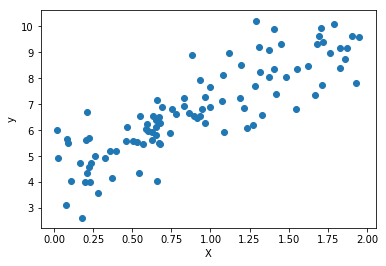

In [4]:
import matplotlib.pyplot as plt

plt.scatter(X,y)
plt.xlabel('X')
plt.ylabel('y')

Now let’s compute θ using the Normal Equation. We will use the inv() function from
NumPy’s Linear Algebra module (np.linalg) to compute the inverse of a matrix, and
the dot() method for matrix multiplication

In [5]:
X_b = np.c_[np.ones((100,1)),X]  #add x0 = 1 to each instance
theta_best = np.linalg.inv(X_b.T.dot(X_b)).dot(X_b.T).dot(y)

In [6]:
theta_best

array([[4.33791193],
       [2.67384416]])

The actual function that we used to generate the data is y = 4 + 3x0 + Gaussian noise. Close
enough, but the noise made it impossible to recover the exact parameters of the original
function.

Now you can make predictions using θ:

In [8]:
X_new = np.array([[0],[2]])
X_new_b = np.c_[np.ones((2,1)),X_new] #add x0=1 to each instance
y_predict = X_new_b.dot(theta_best)
y_predict

array([[4.33791193],
       [9.68560025]])

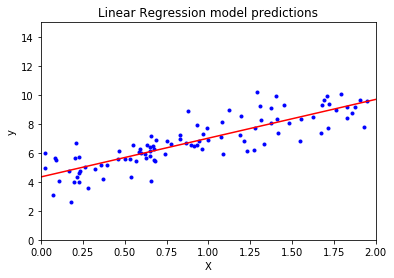

In [9]:
#let's plot

plt.plot(X,y,'b.')
plt.plot(X_new,y_predict,'r-')
plt.xlabel('X')
plt.ylabel('y')
plt.axis([0, 2, 0, 15])
plt.title('Linear Regression model predictions')
plt.show()

The equivalent code in scikit-learn:

In [10]:
from sklearn.linear_model import LinearRegression
lin_reg = LinearRegression()
lin_reg.fit(X,y)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [13]:
lin_reg.intercept_, lin_reg.coef_

(array([4.33791193]), array([[2.67384416]]))

In [14]:
lin_reg.predict(X_new)

array([[4.33791193],
       [9.68560025]])

## Computational complexity

The Normal Equation computes the inverse of XT · X, which is an n × n matrix
(where n is the number of features). 

The computational complexity of inverting such a matrix is typically about O(n2.4) to O(n3) (depending on the implementation). 

In
other words, if you double the number of features, you multiply the computation
time by roughly 22.4 = 5.3 to 23 = 8.

On the positive side, this equation is linear with regards to the number of instances in
the training set (it is O(m)), so it handles large training sets efficiently, provided they
can fit in memory.

Also, once you have trained your Linear Regression model (using the Normal Equation
or any other algorithm), predictions are very fast: the computational complexity
is linear with regards to both the number of instances you want to make predictions
on and the number of features. In other words, making predictions on twice as many
instances (or twice as many features) will just take roughly twice as much time

# Gradient Descent

## Batch Gradient Descent

### Gradient Descent Step 

θ (next step) = θ − η∇θ MSE (θ)

In [15]:
#implementing this algorithm


eta = 0.1 #learning rate
n_iterations = 1000
m = 100

theta = np.random.randn(2,1) #random initialisation

for iteration in range(n_iterations):
    gradients = 2/m * X_b.T.dot(X_b.dot(theta)-y)
    theta = theta - eta*gradients

In [16]:
theta

array([[4.33791193],
       [2.67384416]])

Hey, that’s exactly what the Normal Equation found! Gradient Descent worked perfectly.
But what if you had used a different learning rate eta?

To find a good learning rate, you can use grid search (see Chapter 2). However, you
may want to limit the number of iterations so that grid search can eliminate models
that take too long to converge.

You may wonder how to set the number of iterations. 
- If it is too low, you will still be far away from the optimal solution when the algorithm stops, 
- but if it is too high, you will waste time while the model parameters do not change anymore. 

A simple solution is to <b> set a very large number of iterations but to interrupt the algorithm when the
gradient vector becomes tiny </b> —that is, when its norm becomes smaller than a tiny
number ϵ (called the tolerance)—because this happens when Gradient Descent has
(almost) reached the minimum.

<u>  Convergence Rate </u>

When the cost function is convex and its slope does not change abruptly (as is the
case for the MSE cost function), it can be shown that Batch Gradient Descent with a
fixed learning rate has a convergence rate of O(1/iterations). 

In other words, if you divide the tolerance ϵ by 10 (to have a more precise solution), then the algorithm will have
to run about 10 times more iterations.

## Stochastic Gradient Descent

The main problem with Batch Gradient Descent is the fact that it uses the whole
training set to compute the gradients at every step, which makes it very slow when
the training set is large. 

At the opposite extreme, Stochastic Gradient Descent just
picks a random instance in the training set at every step and computes the gradients
based only on that single instance. 

Obviously this makes the algorithm much faster
since it has very little data to manipulate at every iteration. It also makes it possible to
train on huge training sets, since only one instance needs to be in memory at each
iteration (SGD can be implemented as an out-of-core algorithm.7)

On the other hand, due to its stochastic (i.e., random) nature, this algorithm is much
less regular than Batch Gradient Descent: 
  - instead of gently decreasing until it reaches the minimum, the cost function will bounce up and down, decreasing only on average.
  - Over time it will end up very close to the minimum, but once it gets there it will continue to bounce around, never settling down (see Figure 4-9). 
  - So once the algorithm stops, the final parameter values are good, but not optimal.

When the cost function is very irregular (as in Figure 4-6), this can actually help the
algorithm jump out of local minima, so Stochastic Gradient Descent has a better
chance of finding the global minimum than Batch Gradient Descent does.

Therefore randomness is good to escape from local optima, but bad because it means
that the algorithm can never settle at the minimum. One solution to this dilemma is
to gradually reduce the learning rate.

<b> Simulated annealing </b>
- The steps start out large (which helps make quick progress and escape local minima), then get smaller and smaller, allowing the algorithm to settle at the global minimum. 
- This process is called simulated annealing, because it resembles the process of annealing in metallurgy where molten metal is slowly cooled down

<b> Learning schedule </b>

?: The function that determines the learning rate at each iteration is called the learning schedule. 
    
- If the learning rate is reduced too quickly, you may get stuck in a local minimum, or even end up frozen halfway to the minimum. 
- If the learning rate is reduced too slowly, you may jump around the minimum for a long time and end up with a suboptimal solution if you halt training too early

In [20]:
#This code implements Stochastic Gradient Descent using a simple learning schedule:

n_epochs = 50
t0,t1 = 5,50 #learning schedule hyperparamater

def learning_schedule(t):
    return t0/(t+t1)

theta = np.random.rand(2,1)  #random init

for epoch in range(n_epochs):
    for i in range(m):
        random_index = np.random.randint(m)
        xi = X_b[random_index::random_index+1]
        yi = y[random_index::random_index+1]
        gradients = 2*xi.T.dot(xi.dot(theta) -yi)
        eta = learning_schedule(epoch*m + i)
        theta = theta-eta*gradients

In [21]:
theta

array([[4.27488129],
       [2.65617403]])

By convention we iterate by rounds of m iterations; each round is called an epoch.
While the Batch Gradient Descent code iterated 1,000 times through the whole training
set, this code goes through the training set only 50 times and reaches a fairly good
solution:

Note that since instances are picked randomly, some instances may be picked several
times per epoch while others may not be picked at all. 

If you want to be sure that the
algorithm goes through every instance at each epoch, another approach is to <b> shuffle </b>
the training set, then go through it instance by instance, then shuffle it again, and so
on. However, this generally converges more slowly.

To perform LinReg using SGD with scikitlearn , used SGDReg class which default to optimizing w the sq error cost func

also it doesnt use any regularization(penalty=None)

In [24]:
from sklearn.linear_model import SGDRegressor
sgd_reg = SGDRegressor(n_iter=50, penalty=None, eta0=0.1)
sgd_reg.fit(X,y.ravel())

/Users/piramol/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/stochastic_gradient.py:152: DeprecationWarning: n_iter parameter is deprecated in 0.19 and will be removed in 0.21. Use max_iter and tol instead.
  DeprecationWarning)


SGDRegressor(alpha=0.0001, average=False, early_stopping=False, epsilon=0.1,
       eta0=0.1, fit_intercept=True, l1_ratio=0.15,
       learning_rate='invscaling', loss='squared_loss', max_iter=None,
       n_iter=50, n_iter_no_change=5, penalty=None, power_t=0.25,
       random_state=None, shuffle=True, tol=None, validation_fraction=0.1,
       verbose=0, warm_start=False)

In [25]:
sgd_reg.intercept_, sgd_reg.coef_

(array([4.35950952]), array([2.71312528]))

## Mini-batch Gradient Descent

<u> What is it? </u>

At each step, instead of computing the gradients based on the full training set (as in Batch GD) 
or based on just one instance (as in Stochastic GD), 

Mini-batch GD computes the gradients on <b> small random sets of instances called minibatches.</b>

The main advantage of Mini-batch GD over Stochastic GD is that you can
get a performance boost from hardware optimization of matrix operations, especially
when using GPUs.

The algorithm’s progress in parameter space is less erratic than with SGD, especially
with fairly large mini-batches. As a result, Mini-batch GD will end up walking
around a bit closer to the minimum than SGD. But, on the other hand, it may be
harder for it to escape from local minima 



# Polynomial Regression

<u> What is it? </u>

If data is more complex, we can still use a linear model to fit the nonlinear data by adding powers of each feature 
as new features and then train a linear model on this extended set of features

Text(0.5, 1.0, 'Generated nonlinear and noisy dataset')

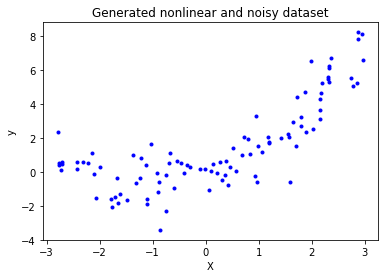

In [28]:
m = 100
X = 6*np.random.rand(m,1)-3
y = 0.5 * X**2 + X + np.random.randn(m,1)

plt.plot(X,y,'b.')
plt.xlabel('X')
plt.ylabel('y')
plt.title('Generated nonlinear and noisy dataset')

Clearly cant use a straight line.

Let's use scikitlearn's polynomiafeatures class to 
- transform our training data
- adding the square of each feature in the trning set as new features

In [29]:
from sklearn.preprocessing import PolynomialFeatures

In [31]:
poly_features = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly_features.fit_transform(X)

In [32]:
X[0]

array([-0.75060558])

In [33]:
X_poly[0]

array([-0.75060558,  0.56340873])

X_poly now contains the original feature of X plus the square of this feature. Now you
can fit a LinearRegression model to this extended training data

In [34]:
lin_reg = LinearRegression()
lin_reg.fit(X_poly,y)
lin_reg.intercept_, lin_reg.coef_

(array([-0.11388178]), array([[1.03914699, 0.49168356]]))

In [40]:
lin_reg_pred_y = lin_reg.predict(X_poly)

Text(0, 0.5, 'y')

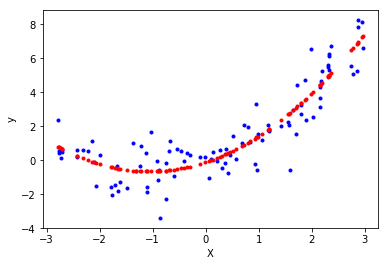

In [50]:
plt.plot(X,y,'b.') #øbtained
plt.plot(X, lin_reg_pred_y, 'r.') #predicted
plt.plot()
plt.xlabel('X')
plt.ylabel('y')

Note that when there are multiple features, Polynomial Regression is capable of finding
relationships between features (which is something a plain Linear Regression
model cannot do). This is made possible by the fact that PolynomialFeatures also
adds all combinations of features up to the given degree.

# Learning Curves

If you perform high-degree Polynomial Regression, you will likely fit the training
data much better than with plain Linear Regression.

Of course, polynomreg could massively overfit where linearreg underfits.

We need a model that generalizes best! 

But in general we won't know what function generated the data so <b> how can we decide how complex our model should be? </b>

How can you tell
that your model is overfitting or underfitting the data?

One way is to look ay <b> learning curves </b>

<u> What are they? </u>

these are plots of the model’s performance on the training set and the validation set as a function of the training set size.

To generate the plots, simply train the model several times on different sized subsets of the training set. 

The following code defines a function that plots the learning
curves of a model given some training data:

In [64]:
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

def plot_learning_curves(model, X, y):
    X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2)
    train_errors, val_errors = [], []
    for m in range(1, len(X_train)):
        model.fit(X_train[:m], y_train[:m])
        y_train_predict = model.predict(X_train[:m])
        y_val_predict = model.predict(X_val)
        train_errors.append(mean_squared_error(y_train_predict, y_train[:m]))
        val_errors.append(mean_squared_error(y_val_predict, y_val))
    plt.plot(np.sqrt(train_errors), "r-+", linewidth=2, label="train")
    plt.plot(np.sqrt(val_errors), "b-", linewidth=3, label="val")
    plt.ylim([0,5])
    plt.gca().legend(('training set','validation set'))

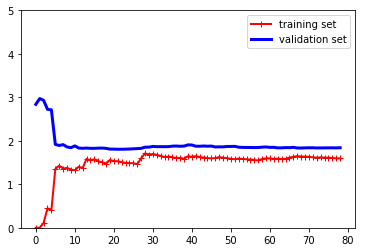

In [65]:
lin_reg = LinearRegression()
plot_learning_curves(lin_reg, X, y)

### What's going on? 

<u> Training set: </u>
  - when there are just one or two instances in the training set, the model can fit them perfectly, which is why the curve starts at zero
  - as new instances are added to the training set, it becomes impossible for the model to fit the training data perfectly, both because the data is noisy and because it is not linear at all.
  - the error on the training data goes up until it reaches a plateau, at which point adding new instances to the training set doesn’t make the average error much better or wors
  
  
<u> Validation set: </u>
- When the model is trained on very few training instances, it is incapable of generalizing properly, which is why the validation error is initially quite big
- as the model is shown more training examples, it learns and thus the validation error slowly goes down. 
- However, once again a straight line cannot do a good job modeling the data, so the error ends up at a plateau, very close to the other curve

These learning curves are typical of an underfitting model. Both curves have reached
a plateau; they are close and fairly high.

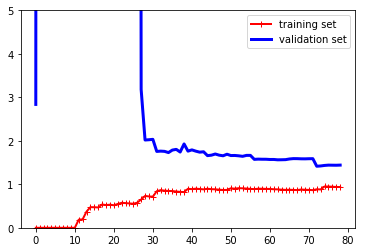

In [66]:
#Now let’s look at the learning curves of a 10th-degree polynomial model on the same data (Figure 4-16):
from sklearn.pipeline import Pipeline

polynomial_regression = Pipeline((
                ("poly_features", PolynomialFeatures(degree=10, include_bias=False)),
                ("sgd_reg", LinearRegression()),
    ))
plot_learning_curves(polynomial_regression, X, y)

These learning curves look a bit like the previous ones, but there are two very important
differences:
    
- The error on the training data is much lower than with the Linear Regression model.
- There is a gap between the curves. This means that the model performs significantly better on the training data than on the validation data, which is the hallmark of an overfitting model. However, if you used a much larger training set, the two curves would continue to get closer.

### Bias/Variance Tradeoff

An important theoretical result of statistics and Machine Learning is the fact that a
model’s generalization error can be expressed as the sum of three very different
errors:
    
<i> Bias </i>

>This part of the generalization error is due to wrong assumptions, such as assuming
that the data is linear when it is actually quadratic. A high-bias model is most
likely to underfit the training data.10

<i> Variance </i>

>This part is due to the model’s excessive sensitivity to small variations in the
training data. A model with many degrees of freedom (such as a high-degree polynomial
model) is likely to have high variance, and thus to overfit the training
data

<i> Irreducible Error </i>

>This part is due to the noisiness of the data itself. The only way to reduce this
part of the error is to clean up the data (e.g., fix the data sources, such as broken
sensors, or detect and remove outliers).


Increasing a model’s complexity will typically increase its variance and reduce its bias.
Conversely, reducing a model’s complexity increases its bias and reduces its variance.
This is why it is called a tradeoff.